In [1]:
from tqdm import tqdm
from zipfile import ZipFile
import os

# Image libraries for image processing
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from libdnn import dnn

# Visualizations will be shown in the notebook.
%matplotlib inline

'''
    Function to convert a RGB image to grayscale image
'''
def rgb2gray(img):
    gray = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
    return gray

'''
    Function to get probabilities for all classes, where index in array is class and value at index is probability.
    
    @Arguments
        tensor_op: Output of classification session, having list of probabilities at index as class number.
        total_images_in_set: total number of images classified in 'tensor_op'
        top_n: how many classifications with more probability to choose from the set.
    @Return
        'top_n' classes having highest probabilities as a list containing tuples having class and probability pairs.
'''
def zipProbabilityWithClass(tensor_op, total_images_in_set, top_n):
    tpf_p_l = [None]*total_images_in_set
    for i in range(total_images_in_set):
        tpf_p = []
        tpf_d = {}
        pb = tensor_op[i][0]
        for p in range(len(pb)):
            tpf_p.append(pb[p])
            tpf_d[pb[p]] = p 
        tpf_p.sort(reverse=True)
        #print(tpf_p)
        tpf_p_l[i] = []
        itm_l = []
        for j in range(top_n):
            tpf_p_l[i].append(tpf_d[tpf_p[j]])
            itm_l.append(tpf_p[j])
        tpf_p_l[i] = list(zip(tpf_p_l[i], itm_l))
    return tpf_p_l

'''
    Read the labels from the input file name 'class_file'.
'''
def getClassesFromFile(class_file):
    file = open(class_file, 'r')
    txt = file.read().split('\n')[1:]
    file.close()
    signs = []
    for line in txt:
        signs.append(line.split(',')[-1])
    return signs

'''
    Function to prepare images for training.
    Preparation is done as follows:
        > Convert to grayscale(32x32)
        > normalize the image using formula pixel = (pixel - 128)/128
        > Change shape to 32x32x1
    Output structure of set is same as input.
'''
def prepareImageSet(image_set, label_set):
    #convert to grayscale
    image_set = [((rgb2gray(img)-128)/128).reshape((32,32,1)) for img in image_set]
    return image_set, label_set

'''
    Read the images from 'image_dir' having names in list 'image_names' and prepare a set which
    would be used for prediction.
    Returns two sets, one normal and one grayscale.
'''
def prepareSetWithNewImages(image_dir, image_names):
    test_images = []
    test_images_g = []
    for i in range(len(image_names)):
        img = Image.open(image_dir+image_names[i])
        resized_img = img.resize((32, 32))
        resized_arr = np.asarray(resized_img)
        test_images.append(resized_arr)
        resized_arr = ((rgb2gray(resized_arr)-128)/128).reshape((32,32,1))
        test_images_g.append(resized_arr)
    return test_images, test_images_g

'''
    Extracts data from zip file
    src: name of the source zip file
    tgt_dir: target directory, where contents need to be extracted
'''
def unzip(src, tgt_dir):
    zip_ref = ZipFile(src, 'r')
    zip_ref.extractall(tgt_dir)
    zip_ref.close()

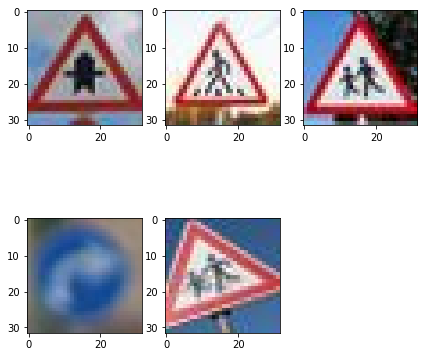

In [2]:
test_img_dir = "./test_images/"
test_img_names = ["img1.jpg", "img2.jpg", "img3.jpg", "img4.jpg", "img5.jpg"]

# test_images are color images and test_images_g are grayscale equivalents
test_images, test_images_g = prepareSetWithNewImages(test_img_dir, test_img_names)
y_new = [11, 27, 28, 33, 28]
fig = plt.figure(figsize=(7,7))
for i in range(5):
    sf = fig.add_subplot(2, 3, i+1)
    plt.imshow(test_images[i])
# Load signs from file "signames.csv"
signs = getClassesFromFile("signames.csv")

In [13]:
def np4d_to_list(np_arr):
    ns = np_arr.shape
    nl = []
    for oc in range(ns[3]):
        nl.append(list())
        for ic in range(ns[2]):
            nl[-1].append(list())
            for w in range(ns[1]):
                nl[-1][-1].append(list())
                for h in range(ns[0]):
                    nl[-1][-1][-1].append(np_arr[h][w][ic][oc])
    return nl

def np3d_to_list(np_arr):
    ns = np_arr.shape
    nl = []
    for oc in range(ns[2]):
        nl.append(list())
        for w in range(ns[1]):
            nl[-1].append(list())
            for h in range(ns[0]):
                nl[-1][-1].append(np_arr[h][w][oc])
    return nl

def np1d_to_list(np_arr):
    return np_arr.tolist()

In [9]:
# Open weights file and evaluate the dictionary to variable 'layers'
with open('weights.txt', 'r') as wf:
    layer_weights_biases = wf.read()
layers = eval(layer_weights_biases)
# Test
print('First layer type:',layers[1]['type'])

First layer type: cnv


In [10]:

def fw_model(input_v, layers):
    batch_sz = len(input_v)
    # convolution layer-1
    op_layer1 = dnn.matadd(dnn.conv2d(input_v, filter_mtx=layers[1]['weights'], strides=(1,1), padding='valid'),
                           [layers[1]['bias']]*batch_sz)
    op_layer1 = dnn.relu(op_layer1)
    op_pool_layer1 = dnn.maxpool_2d(op_layer1, kernel_size=2, strides=(2,2), padding='same')
    
    # convolutional layer-2
    op_layer2 = dnn.matadd(dnn.conv2d(op_pool_layer1, filter_mtx=layers[2]['weights'], strides=(1,1), padding='same'),
                           [layers[2]['bias']]*batch_sz)
    op_layer2 = dnn.relu(op_layer2)
    op_pool_layer2 = dnn.maxpool_2d(op_layer2, kernel_size=2, strides=(2,2), padding='same')
    
    # flatten layer
    op_flat_layer2 = dnn.flatten(op_pool_layer2)
    
    # fully connected layer-3
    op_layer3 = dnn.matadd(dnn.matmul(op_flat_layer2, layers[3]['weights']),
                           [layers[3]['bias']]*batch_sz)
    op_layer3 = dnn.relu(op_layer3)
    
    # fully connected layer-4
    op_layer4 = dnn.matadd(dnn.matmul(op_layer3, layers[4]['weights']),
                          [layers[4]['bias']]*batch_sz)
    op_layer4 = dnn.relu(op_layer4)
    
    # fulle conencted layer-5
    op_layer5 = dnn.matadd(dnn.matmul(op_layer4, layers[5]['weights']),
                          [layers[5]['bias']]*batch_sz)
    logits = dnn.relu(op_layer5)
    return logits

In [19]:

#restore variable state from saved model and get the softmax probabilities for each image
res_l = [None]*1

for i in range(1):
    print("Inference:", i+1)
    res_l[i] = dnn.softmax(fw_model([np3d_to_list(test_images_g[i:i+1][0])], layers))

print("Done.")

Inference: 1
Done.


[[[[[0.1213282605, 0.0493338849, 0.0493338849, 0.0493338849, 0.0493338849, 0.0493338849, 0.0493338849, 0.0542308748, 0.0505522712, 0.0622359973, 0.0493338849, 0.2351353723, 0.0973368041, 0.0493338849, 0.0493338849, 0.0493338849, 0.0995805895, 0.0493338849, 0.2750335236, 0.0493338849, 0.0493338849, 0.0493338849, 0.1021963654, 0.0493338849, 0.1912503771, 0.0493338849, 0.0493338849, 0.0557597884, 0.0493338849, 0.0821524819, 0.0493338849, 0.0724156129, 0.0493338849, 0.0493338849, 0.1476053504, 0.0493338849, 0.0493338849, 0.1092597766, 0.0781639375, 0.0493338849, 0.0493338849, 0.0651299173, 0.0780076937]]]]]


-----------------------


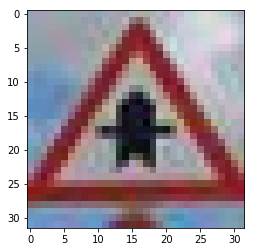

General caution : 0.2750335236
Right-of-way at the next intersection : 0.2351353723
Road narrows on the right : 0.1912503771
Turn left ahead : 0.1476053504
Speed limit (20km/h) : 0.1213282605
-----------------------


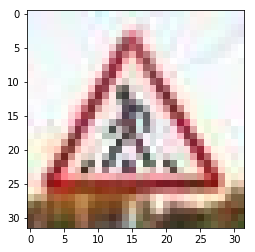

IndexError: list index out of range

In [20]:
#print([np3d_to_list(test_images_g[i:i+1][0])])
# get top 5 predictions for each of the images
print(res_l)
for i in range(1):
    while len(res_l[i]) == 1 and hasattr(res_l[i], '__iter__'):
            res_l[i] = res_l[i][0]
    res_l[i] = [res_l[i]]

tpf_p_l = zipProbabilityWithClass(res_l, 1, 5)

#Display votes
fig = plt.figure()
plt.show()
print('-----------------------')
for i in range(5):
    sf = fig.add_subplot(5, 1, i+1)
    plt.imshow(test_images[i])
    plt.show()
    for v in tpf_p_l[i]:
        print(signs[v[0]],":",v[1])
    print('-----------------------')